In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np                          
import pandas as pd                        
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import HTML

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Hyperparameters
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3 & for
# greyscale image this is 1
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
transform = transforms.Compose([transforms.Resize(28),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,], [0.5])
])

# Importing the training & test dataset
mnist_dataset = datasets.MNIST(root="./data", transform=transform, download=True)

dataloader = torch.utils.data.DataLoader(
    mnist_dataset, shuffle=True,
    batch_size=batch_size
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Text(0.5, 0.98, 'Images in the MNIST training set.')

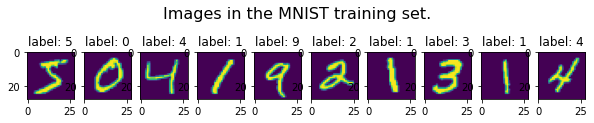

In [4]:
# display the digits in the dataset
plt.figure(figsize=(10,2))
plt.title("Images in the MNIST training set.")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(mnist_dataset.data[i].numpy())
    plt.title(f"label: {mnist_dataset.targets[i].numpy()}")
    
plt.suptitle("Images in the MNIST training set.", fontsize=16)

In [5]:
# Function to display real and fake MNIST Images
def display_images(image_tensor, num_images=25, size=(1, 28, 28)):
    flatten_image = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(flatten_image[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [6]:
# Custom weight initialisation on Generator and Descriminator network
def init_weight(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(m.bias, val=0)

In [7]:
# defining the standalone Discriminator model
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: 1 x 32 x 32
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: 64 x 14 x 14
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: 32 x 14 x 14
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [8]:
# Create the Discriminator
d_model = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    d_model = nn.DataParallel(d_model, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
d_model.apply(init_weight)

# Print the model
print(d_model)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [9]:
# defining the standalone Generator model
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 128, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 8 x 8
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size: 64 x 16 x 16
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # State size: 1 x 32 x 32
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [10]:
# Create the Generator
g_model = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    g_model = nn.DataParallel(g_model, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
g_model.apply(init_weight)

# Print the model
print(g_model)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [11]:
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()

# Setup Adam optimizers for both G and D
optimD = optim.Adam(d_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(g_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
n_epochs = 20

print("Starting Training Loop...")
# For each epoch
for epoch in range(n_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        d_model.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = d_model(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = g_model(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = d_model(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        g_model.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = d_model(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = g_model(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/20][0/469]	Loss_D: 1.4493	Loss_G: 0.4742	D(x): 0.4969	D(G(z)): 0.4999 / 0.4996
[0/20][50/469]	Loss_D: 1.2395	Loss_G: 0.5620	D(x): 0.7318	D(G(z)): 0.2867 / 0.2823
[0/20][100/469]	Loss_D: 1.0794	Loss_G: 0.6487	D(x): 0.9087	D(G(z)): 0.0931 / 0.0910
[0/20][150/469]	Loss_D: 1.0354	Loss_G: 0.6751	D(x): 0.9621	D(G(z)): 0.0370 / 0.0364
[0/20][200/469]	Loss_D: 1.0213	Loss_G: 0.6839	D(x): 0.9802	D(G(z)): 0.0189 / 0.0186
[0/20][250/469]	Loss_D: 1.0153	Loss_G: 0.6876	D(x): 0.9879	D(G(z)): 0.0113 / 0.0112
[0/20][300/469]	Loss_D: 1.0124	Loss_G: 0.6894	D(x): 0.9919	D(G(z)): 0.0075 / 0.0074
[0/20][350/469]	Loss_D: 1.0107	Loss_G: 0.6905	D(x): 0.9942	D(G(z)): 0.0053 / 0.0053
[0/20][400/469]	Loss_D: 1.0096	Loss_G: 0.6912	D(x): 0.9956	D(G(z)): 0.0040 / 0.0040
[0/20][450/469]	Loss_D: 1.0089	Loss_G: 0.6916	D(x): 0.9966	D(G(z)): 0.0031 / 0.0031
[1/20][0/469]	Loss_D: 1.0087	Loss_G: 0.6917	D(x): 0.9969	D(G(z)): 0.0028 / 0.0028
[1/20][50/469]	Loss_D: 1.0082	Loss_G: 0.6920	D(x): 0.99

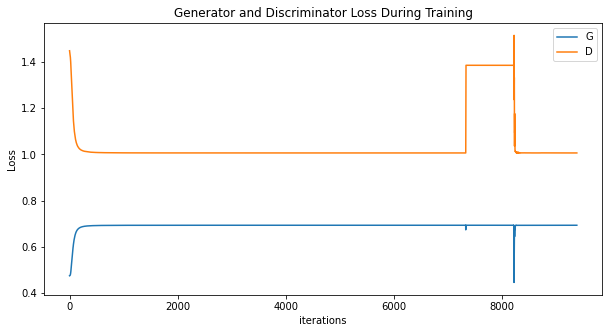

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

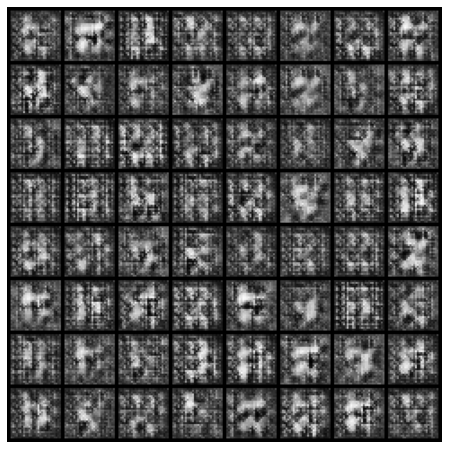

In [19]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())